# Code for competition

In [44]:
import tensorflow as tf
from keras.datasets import mnist
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)
print(tf.config.list_physical_devices())

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

2.10.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load the dataset

In [43]:
samples = []
targets = []

images_ind = [186, 532, 515, 511, 531, 222, 537, 508]
for i in range(0, len(images_ind)):
    for j in range(0, images_ind[i]):
        temp = Image.open(f'training_data_final/Species{i + 1}/{j:05}.jpg').convert('RGB')
        image = np.squeeze(np.expand_dims(temp, axis=0))
        label = tfk.utils.to_categorical(i, len(images_ind))
        samples.append(image)
        targets.append(label)

X = np.array(samples)
y = np.array(targets)
print(X.shape, y.shape)

(3542, 96, 96, 3) (3542, 8)


### Models metadata

In [46]:
input_shape = X.shape[1:]
image_shape = input_shape[:-1]
batch_size = 16
epochs = 200
labels = ["Species1", "Species2", "Species3", "Species4", "Species5", "Species6", "Species7", "Species8"]

### Static augmentation

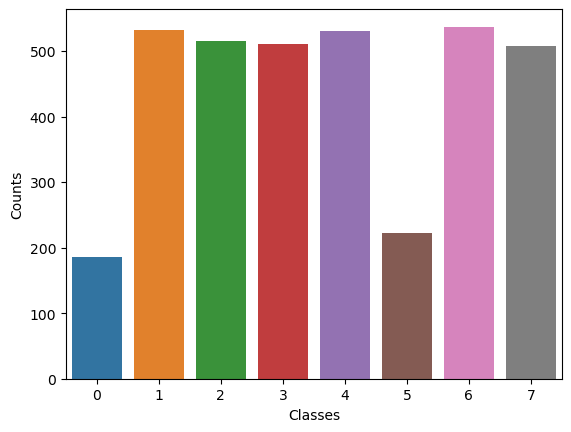

In [49]:
classes, counts = np.unique(np.fromiter([np.argmax(t) for t in y], np.int32), return_counts=True)

plt.ylabel('Counts')
plt.xlabel('Classes')
sns.barplot(x = classes, y = counts)
plt.show()

In [52]:
shift_range = 15
gen = ImageDataGenerator(rotation_range=30,  #TODO: choose the transformations
                         height_shift_range=shift_range,
                         width_shift_range=shift_range,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='nearest')

desired_amount = 700

ref_list = []
aug_samples = []
aug_targets = []

for i in range(0, len(classes)):
    ref_list.append([])
  
for i in range(0, len(y)):
    ref_list[np.argmax(y[i])].append(X[i])

for i in range(0, len(classes)):
    length = len(ref_list[i])
    to_produce = desired_amount - length
    target = tfk.utils.to_categorical(i, len(classes))
    print(f'Computing {to_produce} augmented images for target {i} -> {target}')
    aug_targets_i = np.full((length, len(classes)), target)
    aug_gen_i = gen.flow(np.array(ref_list[i]), 
                         aug_targets_i,
                         batch_size=1,
                         seed=seed,
                         shuffle=True)
    for j in range(0, to_produce):
        aug_samples.append(np.squeeze(next(aug_gen_i)[0]))
        aug_targets.append(target)

X_aug = np.concatenate((X, np.array(aug_samples)))
y_aug = np.concatenate((y, np.array(aug_targets)))
print(X_aug.shape, y_aug.shape)

Computing 514 augmented images for target 0 -> [1. 0. 0. 0. 0. 0. 0. 0.]
Computing 168 augmented images for target 1 -> [0. 1. 0. 0. 0. 0. 0. 0.]
Computing 185 augmented images for target 2 -> [0. 0. 1. 0. 0. 0. 0. 0.]
Computing 189 augmented images for target 3 -> [0. 0. 0. 1. 0. 0. 0. 0.]
Computing 169 augmented images for target 4 -> [0. 0. 0. 0. 1. 0. 0. 0.]
Computing 478 augmented images for target 5 -> [0. 0. 0. 0. 0. 1. 0. 0.]
Computing 163 augmented images for target 6 -> [0. 0. 0. 0. 0. 0. 1. 0.]
Computing 192 augmented images for target 7 -> [0. 0. 0. 0. 0. 0. 0. 1.]
(5600, 96, 96, 3) (5600, 8)


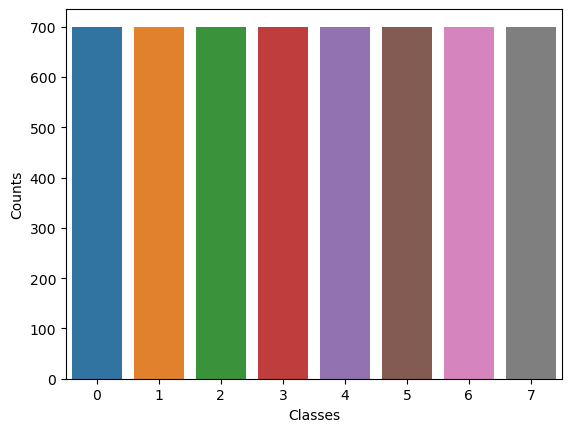

In [54]:
classes, counts = np.unique(np.fromiter([np.argmax(t) for t in y_aug], np.int32), return_counts=True)

plt.ylabel('Counts')
plt.xlabel('Classes')
sns.barplot(x = classes, y = counts)
plt.show()

### Define the model(s)

In [58]:
def build_model(input_shape):
    tf.random.set_seed(seed)
    
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    x = tfkl.Flatten()(input_layer)
    
    x = tfkl.Dense(
        units = 32,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'classifier')(x)
    
    x = tfkl.Dropout(0.3, seed=seed, name='classifier_dropout')(x)

    output_layer = tfkl.Dense(
        units = len(labels), 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'output_layer')(x)
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'standard_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model


def build_conv_model(input_shape):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    x = tfkl.Conv2D(
        filters = 64,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'conv1')(input_layer)
    
    x = tfkl.MaxPooling2D(name='mp1')(x)

    x = tfkl.Conv2D(
        filters = 128,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'conv2')(x)
    
    x = tfkl.MaxPooling2D(name='mp2')(x)

    x = tfkl.Conv2D(
        filters = 256,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'Conv3')(x)
    
    x = tfkl.GlobalAveragePooling2D(name='gap')(x)
    
    x = tfkl.Dropout(0.3, seed=seed, name='gap_dropout')(x)

    x = tfkl.Dense(
        units = 256,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'classifier')(x)
    
    x = tfkl.Dropout(0.3, seed=seed, name='classifier_dropout')(x)

    output_layer = tfkl.Dense(
        units = len(labels), 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'output_layer')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'convolutional_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

# First attempt: Hold Out validation

### Split the dataset (85-15)

In [68]:
X_train, X_val, y_train, y_val = train_test_split(X_aug, y_aug, stratify=y_aug, test_size=0.15)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(4760, 96, 96, 3) (4760, 8)
(840, 96, 96, 3) (840, 8)


### Train the model

In [60]:
model = build_conv_model(input_shape)

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True)]
).history

Epoch 1/200
189/189 [==============================] - 18s 61ms/step - loss: 20.0804 - accuracy: 0.2073 - val_loss: 1.7385 - val_accuracy: 0.4041
Epoch 2/200
189/189 [==============================] - 10s 55ms/step - loss: 1.8589 - accuracy: 0.2937 - val_loss: 1.6758 - val_accuracy: 0.4211
Epoch 3/200
189/189 [==============================] - 11s 57ms/step - loss: 1.7028 - accuracy: 0.3522 - val_loss: 1.6059 - val_accuracy: 0.3929
Epoch 4/200
189/189 [==============================] - 11s 59ms/step - loss: 1.6642 - accuracy: 0.3738 - val_loss: 1.5608 - val_accuracy: 0.4060
Epoch 5/200
189/189 [==============================] - 11s 60ms/step - loss: 1.6207 - accuracy: 0.4013 - val_loss: 1.5160 - val_accuracy: 0.4361
Epoch 6/200
189/189 [==============================] - 11s 60ms/step - loss: 1.5574 - accuracy: 0.4179 - val_loss: 1.4865 - val_accuracy: 0.4248
Epoch 7/200
189/189 [==============================] - 11s 58ms/step - loss: 1.5073 - accuracy: 0.4415 - val_loss: 1.4137 - val_a

### Plot training results

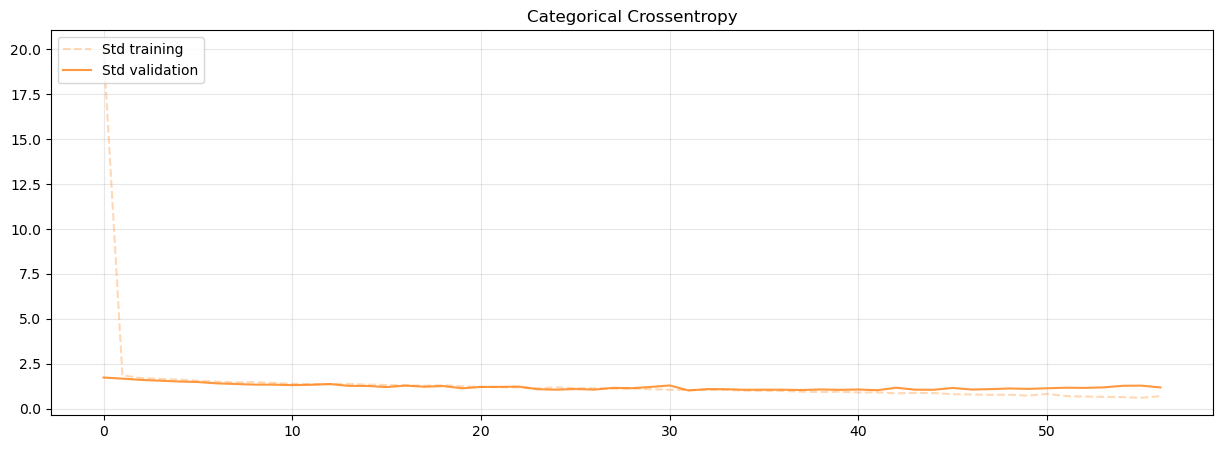

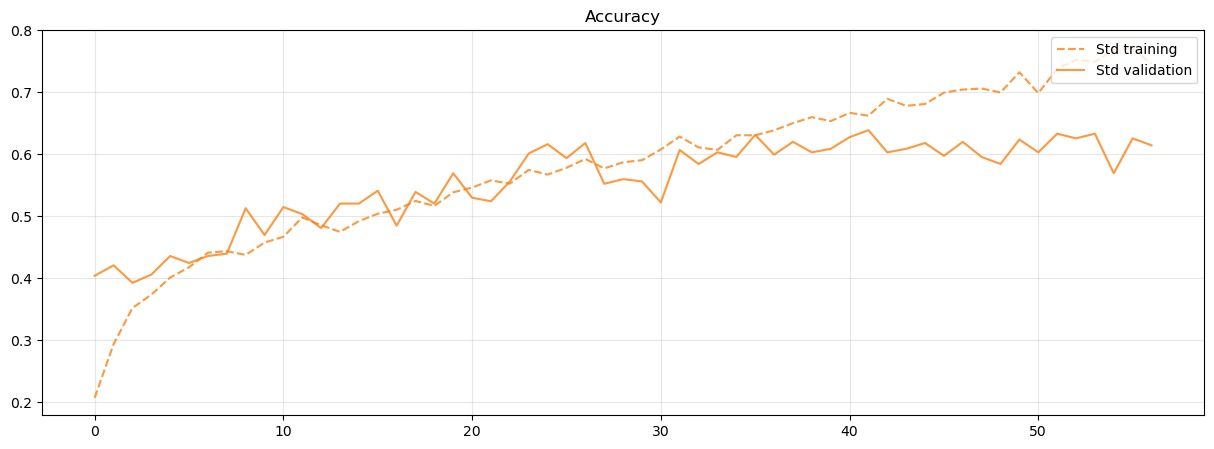

In [61]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Std training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Std training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper right')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

### Plot the confusion matrix (evaluated on the validation set)

17/17 [==============================] - 1s 34ms/step
Accuracy: 0.6391
Precision: 0.5926
Recall: 0.5726
F1: 0.5672


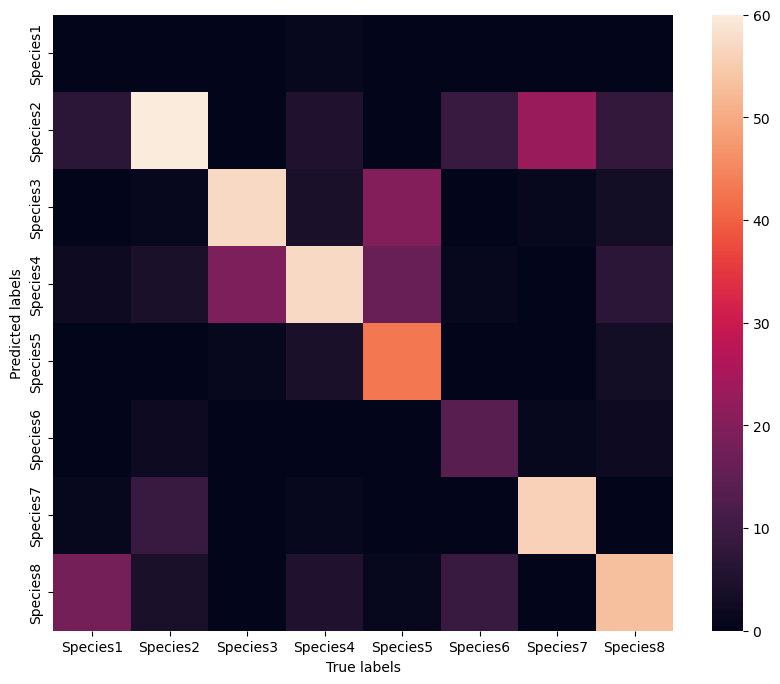

In [63]:
predictions = model.predict(X_val)
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### Save the model

In [69]:
restored_model = tfk.models.load_model('best_model')
restored_loss, restored_acc = restored_model.evaluate(X_val, y_val, verbose=2)  #TODO: not right because validation set can change
loss, acc = model.evaluate(X_val, y_val, verbose=2)
if acc > restored_acc:  # know that this is conceptually wrong
    print("Model improved!")
    model.save('best_model')
else:
    print("No improvement!")

27/27 - 2s - loss: 1.3497 - accuracy: 0.5524 - 2s/epoch - 57ms/step
27/27 - 1s - loss: 1.3497 - accuracy: 0.5524 - 1s/epoch - 48ms/step
No improvement!
